In [1]:
from collections import defaultdict, Counter
import pandas as pd
import sys
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from Bio import SeqIO
from statannotations.Annotator import Annotator
import itertools
import pybedtools
from os.path import exists
from pathlib import Path

In [2]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

In [4]:
sys.path.append(f"{PROJECT_DIR_s}2_train_models/")
from data_loading import one_hot_encode

# In-silico deletion

## Data preparation

In [38]:
s = "HCT116"
model_type = "strand_merged_umap"
p = "divergent"
ds = ["distal", "proximal"]
types = ["wt", "mt"]

In [39]:
df_hits = pd.read_table(f"{PROJECT_DIR_o}procapnet/finemo/{s}_{p}_hits_filtered.tsv")

In [40]:
# revTSS position, fwdTSS position, maxTSS strand

mapping = {}
for d in ds:
	b = pybedtools.BedTool(f"{PROJECT_DIR_d}bed_plot/{s}_{p}_{d}.bed")
	for i in b:
		mapping["_".join(i.fields[:3])] = (int(i.fields[-3]), int(i.fields[-2]), i.fields[-1])

In [8]:
motifs = list(set(df_hits["motif"]))
len(motifs)

11

## Get sequences

In [9]:
inputfile = f"{PROJECT_DIR_s}genomes/hg38/hg38.fasta"
with open(inputfile, "r") as f:
	fdict = SeqIO.to_dict(SeqIO.parse(f, "fasta"))

In [10]:
def get_sequences(motif, t, outputfile, in_window=1000):
	seqs = []
	half_window = in_window//2
	df = df_hits[df_hits["motif"]==motif]
	for index, row in df.iterrows():
		chrom, start, end = row["peak_name"].split("_")
		center = (int(start)+int(end))//2
		seq = fdict[chrom][center-half_window:center+half_window].seq.upper()
		wt_seq = one_hot_encode(seq)
		if t == "wt":
			seqs.append(wt_seq.T)
		else:
			m_start, m_end = row["start"], row["end"]
			# replace motif with [0,0,0,0]
			mt_seq = wt_seq
			for i in range(m_start-(center-half_window), m_end-(center-half_window)):
				mt_seq[i] = [0,0,0,0]
			seqs.append(mt_seq.T)
	seqs = np.array(seqs)
	np.save(outputfile, seqs)

In [11]:
for motif, t in itertools.product(motifs, types):
	outputfile = f"{PROJECT_DIR_o}procapnet/prediction/{motif}_{t}_elements.npy"
	get_sequences(motif, t, outputfile)

## Prediction

In [14]:
# add gpu 

script = f"{PROJECT_DIR_s}slurm/predict.sh"
scale = "True"
for motif, t in itertools.product(motifs, types):
	inputfile = f"{PROJECT_DIR_o}procapnet/prediction/{motif}_{t}_elements.npy"
	output_prefix = f"{PROJECT_DIR_o}procapnet/prediction/{motif}_{t}_elements."
	commands = ["sbatch", script,
				s,
				model_type,
				f"{PROJECT_DIR_o}procapnet/",
				inputfile,
				output_prefix,
				scale,
				str(types.index(t))
				]
	print(" ".join(commands))

sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/predict.sh HCT116 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/SP_wt_elements.npy /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/SP_wt_elements. True 0
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/predict.sh HCT116 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/SP_mt_elements.npy /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/SP_mt_elements. True 1
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/predict.sh HCT116 strand_mer

# Upstream vs. Downstream of TSS

In [ ]:
# Check the effects on count prediction of a given strand
# Try both maxTSS and minTSS

In [54]:
pred_profs = {}
for motif, t in itertools.product(motifs, types):
	inputfile = f"{PROJECT_DIR_o}procapnet/prediction/{motif}_{t}_elements.scaled_profiles.npy"
	pred_profs[(motif,t)] = np.load(inputfile)

In [55]:
# Get log2FC for transcription level on each strand

FCs = defaultdict(list)
for motif in motifs:
	for n in range(len(pred_profs[(motif,t)])):
		fwd = []
		rev = []
		for t in types:
			fwd.append(sum(pred_profs[(motif,t)][n][0]))
			rev.append(sum(pred_profs[(motif,t)][n][1]))
		# mt/wt
		FCs[motif].append((fwd[1]/fwd[0], rev[1]/rev[0]))

In [56]:
results = []
for motif in motifs:
	df = df_hits[df_hits["motif"]==motif].reset_index(drop=True)
	for index, row in df.iterrows():
		chrom, m_start, m_end = row["chr"], row["start"], row["end"]
		motif_center = (int(m_start) + int(m_end))//2
		revTSS_position, fwdTSS_position, maxTSS_strand = mapping[row["peak_name"]]
		fwdFC, revFC = FCs[motif][index]

		# Make it consistent for both fwdTSS and revTSS
		# negative values: upstream of TSS
		# positive values: downstream of TSS
		fwdD = motif_center - fwdTSS_position
		label = "maxTSS" if maxTSS_strand == "+" else "minTSS"
		results.append([motif, fwdFC, fwdD, label])

		revD = revTSS_position - motif_center
		label = "minTSS" if maxTSS_strand == "+" else "maxTSS"
		results.append([motif, revFC, revD, label])
		
df_fc = pd.DataFrame(results, columns=["motif", "FC", "distance_to_TSS", "TSS_type"])
df_fc["pos"] = df_fc["distance_to_TSS"].apply(lambda x: "Downstream of TSS" if x >= 0 else "Upstream of TSS")
df_fc.head(2)

,motif,FC,distance_to_TSS,TSS_type,pos
0,SP,0.835252,-329,maxTSS,Upstream of TSS
1,SP,1.336290,125,minTSS,Downstream of TSS


In [50]:
tss_types = ["maxTSS", "minTSS"]
df = df_fc[((df_fc["TSS_type"]=="maxTSS") & (df_fc["pos"]=="Upstream of TSS")) | ((df_fc["TSS_type"]=="minTSS") & (df_fc["pos"]=="Downstream of TSS"))]
for motif in motifs:
	print(motif, Counter(df[df["motif"]==motif]["pos"]))

SP Counter({'Upstream of TSS': 19727, 'Downstream of TSS': 4125})
AP1 Counter({'Upstream of TSS': 6606, 'Downstream of TSS': 1765})
NRF1 Counter({'Upstream of TSS': 3855, 'Downstream of TSS': 1034})
ETS Counter({'Upstream of TSS': 12720, 'Downstream of TSS': 5074})
YY1 Counter({'Upstream of TSS': 872, 'Downstream of TSS': 496})
ZBTB33 Counter({'Upstream of TSS': 3785, 'Downstream of TSS': 1340})
TATA Counter({'Upstream of TSS': 563, 'Downstream of TSS': 130})
CREB Counter({'Upstream of TSS': 7191, 'Downstream of TSS': 2073})
NFY Counter({'Upstream of TSS': 4698, 'Downstream of TSS': 950})
ZNF143 Counter({'Upstream of TSS': 492, 'Downstream of TSS': 88})
CTCF Counter({'Upstream of TSS': 1438, 'Downstream of TSS': 311})


In [57]:
def plot_FC(order, outputfile):
	fig, ax = plt.subplots(figsize=(5,3))
	df = df_fc[((df_fc["TSS_type"]=="maxTSS") & (df_fc["pos"]=="Upstream of TSS")) | ((df_fc["TSS_type"]=="minTSS") & (df_fc["pos"]=="Downstream of TSS"))]
	hue_plot_params = {"data": df,
						"x": "motif",
						"y": "FC",
						"hue": "pos",
						"hue_order": ["Downstream of TSS", "Upstream of TSS"],
						"order": order,
						"palette": ["#FFD700", "#b3de69"],
					    "showfliers": False
						}
	g = sns.boxplot(ax=ax, **hue_plot_params)
	g.spines[["right", "top"]].set_visible(False)
	g.axhline(y=1, ls="--", c="#636363")
	legend = g.legend(loc="upper right", bbox_to_anchor=(0.95,1), ncol=2, frameon=False, fontsize=sfontsize)

	g.set_ylabel("FC (mt/wt)", fontsize=bfontsize, fontweight="bold")
	g.tick_params(axis="y", labelsize=sfontsize)
	g.set_ylim([0,2.2])
	g.set_yticks([0,0.5,1,1.5,2])
	
	g.set_xlabel("")
	g.tick_params(axis="x", labelsize=bfontsize, rotation=30)
	for label in g.get_xticklabels():
		label.set_fontweight("bold")
		label.set_ha("right")
	
	pairs = [[(motif, "Upstream of TSS"), (motif, "Downstream of TSS")] for motif in order]
	annotator = Annotator(g, pairs, **hue_plot_params)
	annotator.configure(test='Mann-Whitney', text_format="star", 
						comparisons_correction="BH",
						verbose=False, text_offset=1, fontsize=sfontsize)
	annotator.apply_and_annotate()

	plt.savefig(outputfile, bbox_inches="tight", transparent=True) 

In [58]:
order = ["ZNF143", "CTCF", "AP1", "SP", "NFY", 
		 "NRF1", "CREB", "ETS", "ZBTB33", "YY1"]

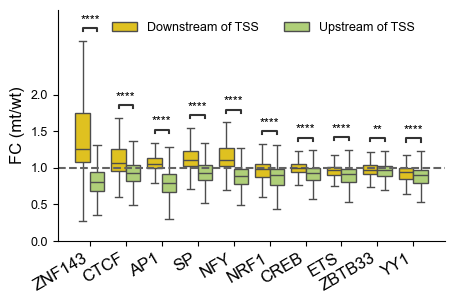

In [59]:
# Downstream of minTSS, Upstream of maxTSS

outputfile = f"{PROJECT_DIR_o}figures/Fig5b.pdf"
plot_FC(order, outputfile)